In [ ]:
function ClickConnect(){
  console.log("Connnect Clicked - Start"); 
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End"); 
};
setInterval(ClickConnect, 60000)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/FCN2s"

/content/drive/My Drive/FCN2s


**Maxime : Different images have different sizes. For now I only keep the most frequent size format. Later perhaps resize**

**Also later need to combine with table detection to erase non table part**

**Also also, need to do the DeepDeSRT preprocessing**

In [ ]:
from PIL import Image
import numpy as np

shape_list = []

for im in os.listdir('./data/images'):
  with Image.open('./data/images/'+im) as image:
    shape_list.append(np.shape(np.array(image)))

from collections import Counter
Counter(shape_list)

#NEED TO HANDLE DIFFERENT SHAPED IMAGES

Counter({(2544, 3312, 3): 5,
         (2550, 3312, 3): 13,
         (3300, 2544, 3): 32,
         (3300, 2560, 3): 50})

In [ ]:
from PIL import Image
total_images = os.listdir('./data/images')

total_annotations = os.listdir('./data/ground_truths')

shapefit_images = [x for x in total_images if np.shape(np.array(Image.open('./data/images/'+x)))==(3300, 2560, 3)]

# 80/20 trainval/test split
# 80/20 train/val split


with open('./data/trainval.txt','w') as f:
  for image in shapefit_images[:int(0.8*len(shapefit_images))]:
    print(image[:-4],file=f)

with open('./data/train.txt','w') as f:
  for image in shapefit_images[:int(0.8*int(0.8*len(shapefit_images)))]:
    print(image[:-4],file=f)

with open('./data/val.txt','w') as f:
  for image in shapefit_images[int(0.8*int(0.8*len(shapefit_images))):int(0.8*len(shapefit_images))]:
    print(image[:-4],file=f)


with open('./data/test.txt','w') as f:
  for image in shapefit_images[int(0.8*len(shapefit_images)):]:
    print(image[:-4],file=f)


# Weight Sampling Tutorial

If you want to fine-tune one of the trained original SSD models on your own dataset, chances are that your dataset doesn't have the same number of classes as the trained model you're trying to fine-tune.

This notebook explains a few options for how to deal with this situation. In particular, one solution is to sub-sample (or up-sample) the weight tensors of all the classification layers so that their shapes correspond to the number of classes in your dataset.

This notebook explains how this is done.

# 0. Our example

For complete explanation, read: https://github.com/pierluigiferrari/ssd_keras/blob/master/weight_sampling_tutorial.ipynb 

## Sub-sample the weights that are causing problems

Instead of throwing the problematic weights away sub-sample them. If the weight tensors of the classification layers of the MS COCO model don't have the right shape for our new model, we'll just **make** them have the right shape. This way we can still benefit from the pre-trained weights in those classification layers. Seems much better than option 2.

In the original example, COCO dataset happens to contain all of the eight classes that we care about. So when we sub-sample the weight tensors of the classification layers, we won't just do so randomly. Instead, we'll pick exactly those elements from the tensor that are responsible for the classification of the 8 classes that we care about.

This is not the case with the table extraction problem. With COCO dataset, labels are: "car", "house", "person", "cow" etc. For us it is celltrue (an empty cell in a table), cellfalse (a cell containing text in a table) or row & column.

However, even if the classes in your dataset were entirely different from the classes in any of the fully trained models, it would still make a lot of sense to use the weights of the fully trained model. Any trained weights are always a better starting point for the training than random initialization, even if your model will be trained on entirely different object classes.

I could perhaps adapt with better weights than COCO, will need to look online.

And of course, in case you happen to have the opposite problem, where your dataset has **more** classes than the trained model you would like to fine-tune, then you can simply do the same thing in the opposite direction: Instead of sub-sampling the classification layer weights, you would then **up-sample** them. Works just the same way as what we'll be doing below.

Let's get to it.

In [3]:
import h5py
import numpy as np
import shutil

from misc_utils.tensor_sampling_utils import sample_tensors

In [4]:
pip install keras==2.2.4

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [5]:
pip install tensorflow==1.13.1 

     |████████████████████████████████| 92.5MB 53kB/s 
     |████████████████████████████████| 368kB 42.9MB/s 
     |████████████████████████████████| 3.2MB 46.8MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


# 1. Load the trained weights file and make a copy

## This part only needs to be run if you do not have initial custom weights (i.e. the first time)

First, we'll load the HDF5 file that contains the trained weights that we need (the source file). In our case this is "`VGG_coco_SSD_300x300_iter_400000.h5`" (download link available in the README of this repo), which are the weights of the original SSD300 model that was trained on MS COCO.

Then, we'll make a copy of that weights file. That copy will be our output file (the destination file).

In [6]:
import os
os.getcwd()

'/content/drive/My Drive/FCN2s'

In [ ]:
# TODO: Set the path for the source weights file you want to load.

## Download COCO SSD weights from : https://drive.google.com/file/d/1vmEF7FUsWfHquXyCqO17UaXOPpRbwsdj/view
weights_source_path = './weights/VGG_coco_SSD_300x300_iter_400000.h5'

# TODO: Set the path and name for the destination weights file
#       that you want to create.

#weights_destination_path = '../../trained_weights/SSD/VGG_coco_SSD_300x300_iter_400000_subsampled_8_classes.h5'
weights_destination_path = './weights/VGG_coco_SSD_300x300_subsampled_3_classes.h5'

# Make a copy of the weights file.
shutil.copy(weights_source_path, weights_destination_path)

'./weights/VGG_coco_SSD_300x300_subsampled_3_classes.h5'

In [ ]:
# Load both the source weights file and the copy we made.
# We will load the original weights file in read-only mode so that we can't mess up anything.
weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


## Figure out which weight tensors we need to sub-sample

Next, we need to figure out exactly which weight tensors we need to sub-sample. As mentioned above, the weights for all layers except the classification layers are fine, we don't need to change anything about those.

So which are the classification layers in SSD300? Their names are:

In [ ]:
# The structure of the SSD network is such that all the following layers connect directly to the prediction layer (I think). They need to be modified.
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf']

## Figure out which slices to pick

The following section is optional. I'll look at one classification layer and explain what we want to do, just for your understanding. If you don't care about that, just skip ahead to the next section.

We know which weight tensors we want to sub-sample, but we still need to decide which (or at least how many) elements of those tensors we want to keep. Let's take a look at the first of the classifier layers, "`conv4_3_norm_mbox_conf`". Its two weight tensors, the kernel and the bias, have the following shapes:

In [ ]:
conv4_3_norm_mbox_conf_kernel = weights_source_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_source_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 324)
bias:	 (324,)


So the last axis has 324 elements. Why is that?

- MS COCO has 80 classes, but the model also has one 'backgroud' class, so that makes 81 classes effectively.
- The 'conv4_3_norm_mbox_loc' layer predicts 4 boxes for each spatial position, so the 'conv4_3_norm_mbox_conf' layer has to predict one of the 81 classes for each of those 4 boxes.

That's why the last axis has 4 * 81 = 324 elements.

So how many elements do we want in the last axis for this layer?

Let's do the same calculation as above:

- Our dataset has 8 classes, but our model will also have a 'background' class, so that makes 9 classes effectively.
- We need to predict one of those 9 classes for each of the four boxes at each spatial position.

That makes 4 * 9 = 36 elements.

Now we know that we want to keep 36 elements in the last axis and leave all other axes unchanged. But which 36 elements out of the original 324 elements do we want?

Should we just pick them randomly? If the object classes in our dataset had absolutely nothing to do with the classes in MS COCO, then choosing those 36 elements randomly would be fine (and the next section covers this case, too). But in our particular example case, choosing these elements randomly would be a waste. Since MS COCO happens to contain exactly the 8 classes that we need, instead of sub-sampling randomly, we'll just take exactly those elements that were trained to predict our 8 classes.

Here are the indices of the 9 classes in MS COCO that we are interested in:

`[0, 1, 2, 3, 4, 6, 8, 10, 12]`

The indices above represent the following classes in the MS COCO datasets:

`['background', 'person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'traffic_light', 'stop_sign']`

How did I find out those indices? I just looked them up in the annotations of the MS COCO dataset.

While these are the classes we want, we don't want them in this order. In our dataset, the classes happen to be in the following order as stated at the top of this notebook:

`['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'traffic_light', 'motorcycle', 'bus', 'stop_sign']`

For example, '`traffic_light`' is class ID 5 in our dataset but class ID 10 in the SSD300 MS COCO model. So the order in which I actually want to pick the 9 indices above is this:

`[0, 3, 8, 1, 2, 10, 4, 6, 12]`

So out of every 81 in the 324 elements, I want to pick the 9 elements above. This gives us the following 36 indices:

In [ ]:
n_classes_source = 81
classes_of_interest = [0, 1, 2] #background, celltrue, cellfalse

subsampling_indices = []
for i in range(int(324/n_classes_source)):
    indices = np.array(classes_of_interest) + i * n_classes_source
    subsampling_indices.append(indices)
subsampling_indices = list(np.concatenate(subsampling_indices))

print(subsampling_indices)

[0, 1, 2, 81, 82, 83, 162, 163, 164, 243, 244, 245]


These are the indices of the 36 elements that we want to pick from both the bias vector and from the last axis of the kernel tensor.

This was the detailed example for the '`conv4_3_norm_mbox_conf`' layer. And of course we haven't actually sub-sampled the weights for this layer yet, we have only figured out which elements we want to keep. The piece of code in the next section will perform the sub-sampling for all the classifier layers.

## Sub-sample the classifier weights

The code in this section iterates over all the classifier layers of the source weights file and performs the following steps for each classifier layer:

1. Get the kernel and bias tensors from the source weights file.
2. Compute the sub-sampling indices for the last axis. The first three axes of the kernel remain unchanged.
3. Overwrite the corresponding kernel and bias tensors in the destination weights file with our newly created sub-sampled kernel and bias tensors.

The second step does what was explained in the previous section.

In case you want to **up-sample** the last axis rather than sub-sample it, simply set the `classes_of_interest` variable below to the length you want it to have. The added elements will be initialized either randomly or optionally with zeros. Check out the documentation of `sample_tensors()` for details.

In [ ]:
# TODO: Set the number of classes in the source weights file. Note that this number must include
#       the background class, so for MS COCO's 80 classes, this must be 80 + 1 = 81.
n_classes_source = 81
# TODO: Set the indices of the classes that you want to pick for the sub-sampled weight tensors.
#       In case you would like to just randomly sample a certain number of classes, you can just set
#       `classes_of_interest` to an integer instead of the list below. Either way, don't forget to
#       include the background class. That is, if you set an integer, and you want `n` positive classes,
#       then you must set `classes_of_interest = n + 1`.

classes_of_interest = [0, 1, 2]
#classes_of_interest = 9 # Uncomment this in case you want to just randomly sub-sample the last axis instead of providing a list of indices.

for name in classifier_names:
    # Get the trained weights for this layer from the source HDF5 weights file.
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias = weights_source_file[name][name]['bias:0'].value

    # Get the shape of the kernel. We're interested in sub-sampling
    # the last dimension, 'o'.
    height, width, in_channels, out_channels = kernel.shape
    
    # Compute the indices of the elements we want to sub-sample.
    # Keep in mind that each classification predictor layer predicts multiple
    # bounding boxes for every spatial location, so we want to sub-sample
    # the relevant classes for each of these boxes.
    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    
    # Sub-sample the kernel and bias.
    # The `sample_tensors()` function used below provides extensive
    # documentation, so don't hesitate to read it if you want to know
    # what exactly is going on here.
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    
    # Delete the old weights from the destination file.
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    # Create new datasets for the sub-sampled weights.
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

# Make sure all data is written to our output file before this sub-routine exits.
weights_destination_file.flush()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()


That's it, we're done.

Let's just quickly inspect the shapes of the weights of the '`conv4_3_norm_mbox_conf`' layer in the destination weights file:

In [ ]:
conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 12)
bias:	 (12,)


Nice! Exactly what we wanted, 36 elements in the last axis. Now the weights are compatible with our new SSD300 model that predicts 8 positive classes.

This is the end of the relevant part of this tutorial, but we can do one more thing and verify that the sub-sampled weights actually work. Let's do that in the next section.

## Verify that our sub-sampled weights actually work

In our example case above we sub-sampled the fully trained weights of the SSD300 model trained on MS COCO from 80 classes to just the 8 classes that we needed.

We can now create a new SSD300 with 8 classes, load our sub-sampled weights into it, and see how the model performs on a few test images that contain objects for some of those 8 classes. Let's do it.

In [7]:
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.models import load_model

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_patch_sampling_ops import RandomMaxCropFixedAR
from data_generator.object_detection_2d_geometric_ops import Resize

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

### Set the parameters for the model.

As always, set the parameters for the model. We're going to set the configuration for the SSD300 MS COCO model.

In [8]:
img_height = 300 # Height of the input images
img_width = 300 # Width of the input images
img_channels = 3 # Number of color channels of the input images
subtract_mean = [123, 117, 104] # The per-channel mean of the images in the dataset
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we should set this to `True`, but weirdly the results are better without swapping.
# TODO: Set the number of classes.
n_classes = 2 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
##n_classes is the number of classes without counting the background (even though th background appears in classes_of_interest)

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets.
# scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets.
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
normalize_coords = True

### Test the model (optional)

Build the model and load our newly created, sub-sampled weights into it.

In [ ]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

print((img_height, img_width, img_channels))
print(n_classes)

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels,
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False) #CHANGE mode to 'inference' when testing

print("Model built.")

# 2: Load the sub-sampled weights into the model.

# Load the weights that we've just created via sub-sampling.
weights_path = weights_destination_path

model.load_weights(weights_path, by_name=True)

print("Weights file loaded:", weights_path)



# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Maxime : DeepDeSRT uses a standard SGD with specific parameters, we follow the papers guidelines
#sgd = SGD(lr=10**(-10), momentum=0.99)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
#model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)


model.save('./weights/TchibNet.h5')


(300, 300, 3)
2
Model built.
Weights file loaded: ./weights/VGG_coco_SSD_300x300_subsampled_3_classes.h5
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


# 2. **Train**

## This is the part that actually matters.

In [9]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, TerminateOnNaN
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

In [10]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = './weights/TchibNet.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


**MAXIME: READ THIS AND FIGURE OUT IF NEED TO REMOVE/MODIFY DATA AUGMENTATION 
BIT - IT WAS DONE ON COCO BUT MIGHT BE HARMFUL FOR TABLE EXTRACTION**

ALSO your weights are from COCO, don't forget!!
---


3. Set up the data generators for the training

The code cells below set up the data generators for the training and validation datasets to train the model. The settings below reproduce the original SSD training on Pascal VOC 2007 trainval plus 2012 trainval and validation on Pascal VOC 2007 test.

The only thing you need to change here are the filepaths to the datasets on your local machine. Note that parsing the labels from the XML annotations files can take a while.

Note that the generator provides two options to speed up the training. By default, it loads the individual images for a batch from disk. This has two disadvantages. First, for compressed image formats like JPG, this is a huge computational waste, because every image needs to be decompressed again and again every time it is being loaded. Second, the images on disk are likely not stored in a contiguous block of memory, which may also slow down the loading process. The first option that DataGenerator provides to deal with this is to load the entire dataset into memory, which reduces the access time for any image to a negligible amount, but of course this is only an option if you have enough free memory to hold the whole dataset. As a second option, DataGenerator provides the possibility to convert the dataset into a single HDF5 file. This HDF5 file stores the images as uncompressed arrays in a contiguous block of memory, which dramatically speeds up the loading time. It's not as good as having the images in memory, but it's a lot better than the default option of loading them from their compressed JPG state every time they are needed. Of course such an HDF5 dataset may require significantly more disk space than the compressed images (around 9 GB total for Pascal VOC 2007 trainval plus 2012 trainval and another 2.6 GB for 2007 test). You can later load these HDF5 datasets directly in the constructor.

The original SSD implementation uses a batch size of 32 for the training. In case you run into GPU memory issues, reduce the batch size accordingly. You need at least 7 GB of free GPU memory to train an SSD300 with 20 object classes with a batch size of 32.

The DataGenerator itself is fairly generic. I doesn't contain any data augmentation or bounding box encoding logic. Instead, you pass a list of image transformations and an encoder for the bounding boxes in the transformations and label_encoder arguments of the data generator's generate() method, and the data generator will then apply those given transformations and the encoding to the data. Everything here is preset already, but if you'd like to learn more about the data generator and its data augmentation capabilities, take a look at the detailed tutorial in this repository.

The data augmentation settings defined further down reproduce the data augmentation pipeline of the original SSD training. The training generator receives an object ssd_data_augmentation, which is a transformation object that is itself composed of a whole chain of transformations that replicate the data augmentation procedure used to train the original Caffe implementation. The validation generator receives an object resize, which simply resizes the input images.

An SSDInputEncoder object, ssd_input_encoder, is passed to both the training and validation generators. As explained above, it matches the ground truth labels to the model's anchor boxes and encodes the box coordinates into the format that the model needs.

In order to train the model on a dataset other than Pascal VOC, either choose DataGenerator's appropriate parser method that corresponds to your data format, or, if DataGenerator does not provide a suitable parser for your data format, you can write an additional parser and add it. Out of the box, DataGenerator can handle datasets that use the Pascal VOC format (use parse_xml()), the MS COCO format (use parse_json()) and a wide range of CSV formats (use parse_csv()).


In [11]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
images_dir      = './data/images/'

# The directories that contain the annotations.
annotations_dir      = './data/ground_truths/'

# The paths to the image sets.
train_image_set_filename    = './data/train.txt'

val_image_set_filename      = './data/val.txt'

trainval_image_set_filename = './data/trainval.txt'

test_image_set_filename     = './data/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
#classes = ['background',
#           'row', 'column']
classes = ['background',
           'celltrue', 'cellfalse']
  

train_dataset.parse_xml(images_dirs=[images_dir],
                        image_set_filenames=[trainval_image_set_filename],
                        annotations_dirs=[annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[images_dir],
                      image_set_filenames=[test_image_set_filename],
                      annotations_dirs=[annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.
'''
train_dataset.create_hdf5_dataset(file_path='dataset_trainval.h5',
                                  resize=(height,width),
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_test.h5',
                                resize=(height,width),
                                variable_image_size=True,
                                verbose=True)
'''

Loading images into memory: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


"\ntrain_dataset.create_hdf5_dataset(file_path='dataset_trainval.h5',\n                                  resize=(height,width),\n                                  variable_image_size=True,\n                                  verbose=True)\n\nval_dataset.create_hdf5_dataset(file_path='dataset_test.h5',\n                                resize=(height,width),\n                                variable_image_size=True,\n                                verbose=True)\n"

In [12]:
# 3: Set the batch size.

batch_size = 16 # Change the batch size if you like, or if you run into GPU memory issues (initially 32, DeepDeSRT uses 1)

mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	    40
Number of images in the validation dataset:	    10



4. Set the remaining training parameters

We've already chosen an optimizer and set the batch size above, now let's set the remaining training parameters. I'll set one epoch to consist of 1,000 training steps. The next code cell defines a learning rate schedule that replicates the learning rate schedule of the original Caffe implementation for the training of the SSD300 Pascal VOC "07+12" model. That model was trained for 120,000 steps with a learning rate of 0.001 for the first 80,000 steps, 0.0001 for the next 20,000 steps, and 0.00001 for the last 20,000 steps. If you're training on a different dataset, define the learning rate schedule however you see fit.

I'll set only a few essential Keras callbacks below, feel free to add more callbacks if you want TensorBoard summaries or whatever. We obviously need the learning rate scheduler and we want to save the best models during the training. It also makes sense to continuously stream our training history to a CSV log file after every epoch, because if we didn't do that, in case the training terminates with an exception at some point or if the kernel of this Jupyter notebook dies for some reason or anything like that happens, we would lose the entire history for the trained epochs. Finally, we'll also add a callback that makes sure that the training terminates if the loss becomes NaN. Depending on the optimizer you use, it can happen that the loss becomes NaN during the first iterations of the training. In later iterations it's less of a risk. For example, I've never seen a NaN loss when I trained SSD using an Adam optimizer, but I've seen a NaN loss a couple of times during the very first couple of hundred training steps of training a new model when I used an SGD optimizer.


In [ ]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [ ]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='./weights/VGG_coco_SSD_300x300_subsampled_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='./VGG_coco_SSD_300x300_subsampled_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]


5. Train

In order to reproduce the training of the "07+12" model mentioned above, at 1,000 training steps per epoch you'd have to train for 120 epochs. That is going to take really long though, so you might not want to do all 120 epochs in one go and instead train only for a few epochs at a time. You can find a summary of a full training here.

In order to only run a partial training and resume smoothly later on, there are a few things you should note:

    Always load the full model if you can, rather than building a new model and loading previously saved weights into it. Optimizers like SGD or Adam keep running averages of past gradient moments internally. If you always save and load full models when resuming a training, then the state of the optimizer is maintained and the training picks up exactly where it left off. If you build a new model and load weights into it, the optimizer is being initialized from scratch, which, especially in the case of Adam, leads to small but unnecessary setbacks every time you resume the training with previously saved weights.
    In order for the learning rate scheduler callback above to work properly, fit_generator() needs to know which epoch we're in, otherwise it will start with epoch 0 every time you resume the training. Set initial_epoch to be the next epoch of your training. Note that this parameter is zero-based, i.e. the first epoch is epoch 0. If you had trained for 10 epochs previously and now you'd want to resume the training from there, you'd set initial_epoch = 10 (since epoch 10 is the eleventh epoch). Furthermore, set final_epoch to the last epoch you want to run. To stick with the previous example, if you had trained for 10 epochs previously and now you'd want to train for another 10 epochs, you'd set initial_epoch = 10 and final_epoch = 20.
    In order for the model checkpoint callback above to work correctly after a kernel restart, set model_checkpoint.best to the best validation loss from the previous training. If you don't do this and a new ModelCheckpoint object is created after a kernel restart, that object obviously won't know what the last best validation loss was, so it will always save the weights of the first epoch of your new training and record that loss as its new best loss. This isn't super-important, I just wanted to mention it.



**!!In object_detection.2d_generator.py I changed format from .jpg to .png(Maxime)** 


**YOU HAVE PROBLEMS TRAINING TO RECOGNIZE COLUMNS AND ROWS BECAUSE THEIR BOUNDING BOXES HAVE SAME xmin&xmax OR ymin&ymax**

**CELLS HAVE EXTRA INFO: startcol, endcol, startrow, endrow**


In [ ]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.

steps_per_epoch=train_dataset_size//batch_size
print(steps_per_epoch)

initial_epoch   = 0
final_epoch     = 50

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

2
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
2/2 [==============================] - 294s 147s/step - loss: 119.3195 - val_loss: 94187.9141

Epoch 00001: val_loss improved from inf to 94187.91406, saving model to ./weights/VGG_coco_SSD_300x300_subsampled_epoch-01_loss-119.3195_val_loss-94187.9141.h5
Epoch 2/50
2/2 [==============================] - 189s 95s/step - loss: 943341.5087 - val_loss: 133537744.0000

Epoch 00002: val_loss did not improve from 94187.91406
Epoch 3/50
2/2 [==============================] - 174s 87s/step - loss: 209705384.8889 - val_loss: 20322136064.0000

Epoch 00003: val_loss did not improve from 94187.91406
Epoch 4/50
2/2 [==============================] - 216s 108s/step - loss: 26939012352.0000 - val_loss: 311899712.0000

Epoch 00004: val_loss did not improve from 94187.91406
Epoch 5/50
2/2 [==============================] - 171s 86s/step - loss: 59082225.2222 - val_loss: 974360.6875

Epoch 00005: val_loss did not i

In [ ]:
model.save('./weights/TchibNet_trained.h5')



6. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator that we've already set up above. Feel free to change the batch size.

You can set the shuffle option to False if you would like to check the model's progress on the same image(s) over the course of the training.


In [13]:
latest_weights = './weights/VGG_coco_SSD_300x300_subsampled_epoch-50_loss-8.4358_val_loss-9.2697.h5'
model.load_weights(latest_weights, by_name=True)


In [32]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=5,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [33]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ./data/images/Copy of 1556_006.png

Ground truth boxes:

[[   2  220  386  340  466]
 [   2  340  386 2010  466]
 [   2 2010  386 2203  466]
 [   2  220  466  340  570]
 [   2  340  466 2010  570]
 [   2 2010  466 2203  570]
 [   2  220  570  340  670]
 [   2  340  570 2010  670]
 [   2 2010  570 2203  670]
 [   2  220  670  340  816]
 [   2  340  670 2010  816]
 [   2 2010  670 2203  816]
 [   2  220  816  340  920]
 [   2  340  816 2010  920]
 [   2 2010  816 2203  920]
 [   2  220  920  340 1030]
 [   2  340  920 2010 1030]
 [   2 2010  920 2203 1030]
 [   2  220 1030  340 1126]
 [   2  340 1030 2010 1126]
 [   2 2010 1030 2203 1126]
 [   2  220 1126  340 1226]
 [   2  340 1126 2010 1226]
 [   2 2010 1126 2203 1226]
 [   2  220 1226  340 1333]
 [   2  340 1226 2010 1333]
 [   2 2010 1226 2203 1333]]


In [40]:
# 3: Make predictions.

y_pred = model.predict(batch_images)
print(np.shape(y_pred))

(5, 8732, 15)




Now let's decode the raw predictions in y_pred.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a DecodeDetections layer and y_pred would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the decode_detections() function is for. It does exactly what the DecodeDetections layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

decode_detections() with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions.


**Maxime: We will need a reliable rule to set the confidence threshold.**

In [37]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.2,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [38]:
y_pred_decoded

[array([[  2.  ,   0.23, 221.29,  79.67, 265.95,  86.47],
        [  2.  ,   0.23, 221.49,  87.59, 265.54,  94.32],
        [  2.  ,   0.23, 222.03,  71.81, 265.64,  78.56],
        [  2.  ,   0.22, 222.88,  95.61, 264.2 , 102.08],
        [  2.  ,   0.22, 222.99,  63.98, 265.16,  70.62],
        [  2.  ,   0.21, 222.01,  40.07, 266.7 ,  47.18],
        [  2.  ,   0.21, 223.28,  48.19, 265.5 ,  54.78],
        [  2.  ,   0.21, 223.55,  56.12, 264.99,  62.63],
        [  2.  ,   0.2 , 224.58, 103.64, 262.58, 109.79],
        [  2.  ,   0.2 , 220.6 ,  31.83, 267.96,  39.73]]),
 array([[  2.  ,   0.21,  61.4 , 126.38, 110.36, 134.28],
        [  2.  ,   0.21,  60.89, 134.15, 110.87, 142.26],
        [  2.  ,   0.21,  60.7 , 141.96, 111.1 , 150.28],
        [  2.  ,   0.21,  61.92, 118.53, 109.76, 126.37],
        [  2.  ,   0.2 ,  22.31, 213.3 ,  71.16, 221.17],
        [  2.  ,   0.2 ,  22.41, 221.25,  70.3 , 228.94],
        [  2.  ,   0.2 ,  22.75, 126.47,  72.09, 134.32],
        [  2



We made the predictions on the resized images, but we'd like to visualize the outcome on the original input images, so we'll convert the coordinates accordingly. Don't worry about that opaque apply_inverse_transforms() function below, in this simple case it just aplies (* original_image_size / resized_image_size) to the box coordinates.


In [41]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[   2.      0.23 1888.    876.   2269.    951.  ]
 [   2.      0.23 1890.    964.   2266.   1038.  ]
 [   2.      0.23 1895.    790.   2267.    864.  ]
 [   2.      0.22 1902.   1052.   2254.   1123.  ]
 [   2.      0.22 1903.    704.   2263.    777.  ]
 [   2.      0.21 1894.    441.   2276.    519.  ]
 [   2.      0.21 1905.    530.   2266.    603.  ]
 [   2.      0.21 1908.    617.   2261.    689.  ]
 [   2.      0.2  1916.   1140.   2241.   1208.  ]
 [   2.      0.2  1882.    350.   2287.    437.  ]]


In [42]:
#MAXIME 
#REMOVE THE BOXES WHICH ARE CLEARLY IMPOSSIBLE.

y_pred_decoded_inv_subthreshold = y_pred_decoded_inv[i][np.sum(y_pred_decoded_inv[i],axis=1) < 10000,:]






Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.


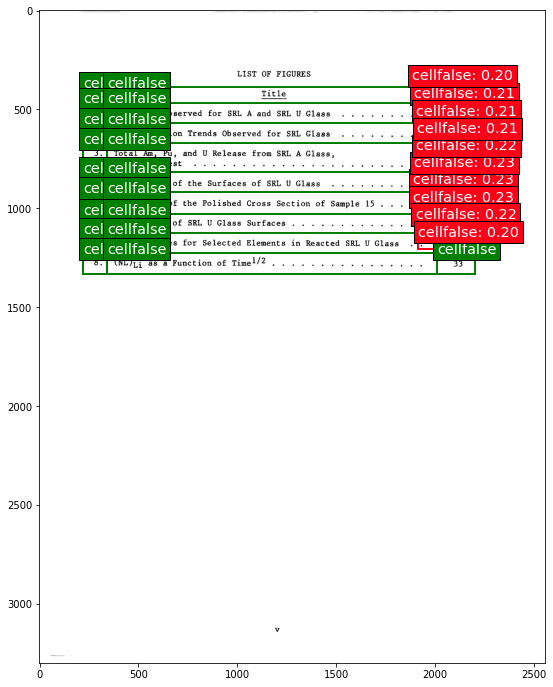

In [43]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'celltrue', 'cellfalse']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv_subthreshold:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

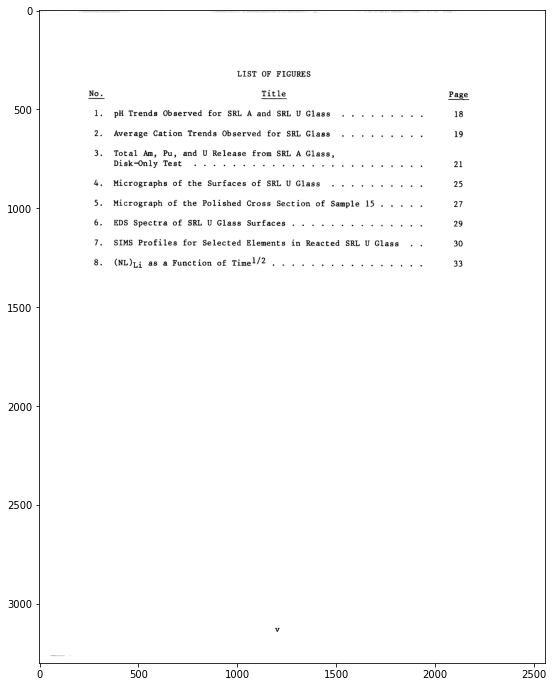

In [44]:

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])


**Caveat: This image is from the validation dataset, so not completely independent from training**

### 5.3. Load some images to test our model on

We sub-sampled some of the road traffic categories from the trained SSD300 MS COCO weights, so let's try out our model on a few road traffic images. The Udacity road traffic dataset linked to in the `ssd7_training.ipynb` notebook lends itself to this task. Let's instantiate a `DataGenerator` and load the Udacity dataset. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [31]:
dataset = DataGenerator()

# TODO: Set the paths to your dataset here.
images_path = './data/images/'
labels_path = './data/ground_truths/'

dataset.parse_csv(images_dir=images_path,
                  labels_filename=labels_path,
                  input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                  include_classes='all',
                  random_sample=False)

print("Number of images in the dataset:", dataset.get_dataset_size())

IsADirectoryError: ignored

Make sure the batch generator generates images of size `(300, 300)`. We'll first randomly crop the largest possible patch with aspect ratio 1.0 and then resize to `(300, 300)`.

In [ ]:
convert_to_3_channels = ConvertTo3Channels()
random_max_crop = RandomMaxCropFixedAR(patch_aspect_ratio=img_width/img_height)
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              random_max_crop,
                                              resize],
                             returns={'processed_images',
                                      'processed_labels',
                                      'filenames'},
                             keep_images_without_gt=False)

In [ ]:
# Generate samples

batch_images, batch_labels, batch_filenames = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: ../../datasets/Udacity_Driving/driving_dataset_consolidated_small/1479505696943867867.jpg

Ground truth boxes:

[[  1   0 148  37 173]
 [  1  40 139  86 172]
 [  1  79 143  95 158]
 [  1 128 143 144 154]
 [  1 149 111 256 210]]


### 5.4. Make predictions and visualize them

In [ ]:
# Make a prediction

y_pred = model.predict(batch_images)

In [ ]:
# Decode the raw prediction.

i = 0

confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin    ymin    xmax    ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.95  40.68 137.04  87.31 167.75]
 [  1.     0.81   0.43 148.85  35.93 172.36]
 [  2.     0.8  148.55 113.82 259.65 209.92]
 [  5.     0.31  75.24  24.65  85.85  52.44]]


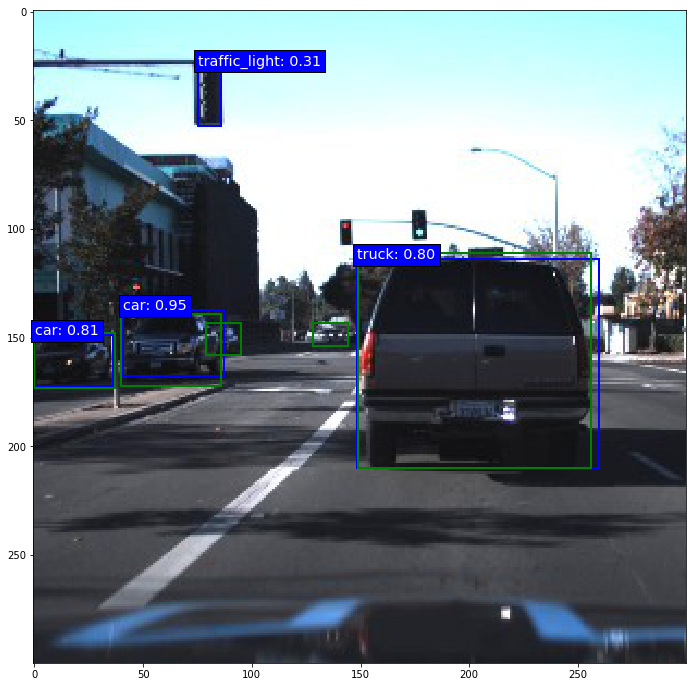

In [ ]:
# Visualize the predictions.

from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist',
           'traffic_light', 'motorcycle', 'bus', 'stop_sign'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
for box in y_pred_thresh[i]:
    class_id = box[0]
    confidence = box[1]
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    label = '{}: {:.2f}'.format(classes[int(class_id)], confidence)
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    class_id = box[0]
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(class_id)])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

Seems as if our sub-sampled weights were doing a good job, sweet. Now we can fine-tune this model on our dataset with 8 classes.